In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import cv2
import imageio.v2 as imageio
import numpy as np
import pandas as pd
from IPython.display import display, Math, Video
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import os
from os import listdir
from os.path import isfile, isdir, join
import time

startInstantTime = time.time()

In [2]:
#Parametros de ejecucion del programa
nombreArchivoInformacion = "./Datos/InformacionEjercicioRegresion.txt"
nombreArchivoDataset = "./Datos/DatasetRegresion.csv"
nombreArchivoAnimacion = "Animación del ADALINE"
tasaAprendizaje = 0.000001
tiempoPausaAnimacion = 0.001

searchFolderPath = "./Figuras/"
imageFileExtension = ".jpg"
animationFileExtension = ".mp4"
framesPorSegundoAnimacion = 15

colorTextoVerde = (35, 155, 86)
colorTextoRojo = (176, 58, 46)

In [3]:
imageFileExtensionsList = [imageFileExtension]

def printColouredText(text, foregroundColor = (0, 0, 0), backgroundColor = (255, 255, 255)):
    return "\033[48;2;{};{};{}m\033[38;2;{};{};{}m{}\033[38;2;0;0;0m\033[48;2;255;255;255m".format(backgroundColor[0], backgroundColor[1], backgroundColor[2], foregroundColor[0], foregroundColor[1], foregroundColor[2], text)

def getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    filesList.sort(key = lambda file: os.path.getmtime(join(searchFolderPath, file)))
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " en la carpeta " + searchFolderPath
    return filesList, informativeMessage

def deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, fileExtensionsList):
    informativeMessage = ""
    filesList = [file for file in listdir(searchFolderPath) if isfile(join(searchFolderPath, file))]
    filesList = [file for file in filesList if file[len(file) - 4:] in fileExtensionsList]
    numberFilesFound = len(filesList)
    if numberFilesFound == 0:
        informativeMessage = "No hay archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    elif numberFilesFound == 1:
        informativeMessage = "Solo hay un archivo con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    else:
        informativeMessage = "Hay " + str(numberFilesFound) + " archivos con extensión " + str(fileExtensionsList) + " para eliminar, en la carpeta " + searchFolderPath
    
    for file in filesList:
        os.remove(join(searchFolderPath, file))
    return informativeMessage

def resizeImage(image, width = None, height = None, interpolationTechnique = cv2.INTER_AREA):
    newImageSize = None
    ratioFactor = 1.0
    (imageHeight, imageWidth) = image.shape[:2]
    
    #The ratio factor is computed (only in case to get exactly one of the parameters (width or height) in None), otherwise, the image will be resized without keep its aspect ratio
    if width is None and height is None:
        return image
    if width is None:
        ratioFactor = height / float(imageHeight)
        newImageSize = (int(imageWidth * ratioFactor), height)
    elif height is None:
        ratioFactor = width / float(imageWidth)
        newImageSize = (width, int(imageHeight * ratioFactor))
    else:
        newImageSize = (width, height)
    resizedImage = cv2.resize(image, newImageSize, interpolation = interpolationTechnique)
    return resizedImage

#El ajuste de tamaño comun a las imagenes esta hecho con reescalado al tamaño maximo/minimo o con un slice/recorte al tamaño minimo
def overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList):
    numberImageFilesFound = len(imageFilesList)
    if numberImageFilesFound >= 1:
        maximumWidthForAllImages = -1
        maximumHeightForAllImages = -1
        #minimumWidthForAllImages = float('inf')
        #minimumHeightForAllImages = float('inf')
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImageWidth = originalImage.shape[1]
            originalImageHeight = originalImage.shape[0]
            if originalImageWidth > maximumWidthForAllImages:
                maximumWidthForAllImages = originalImageWidth
            if originalImageHeight > maximumHeightForAllImages:
                maximumHeightForAllImages = originalImageHeight
            #if originalImageWidth < minimumWidthForAllImages:
                #minimumWidthForAllImages = originalImageWidth
            #if originalImageHeight < minimumHeightForAllImages:
                #minimumHeightForAllImages = originalImageHeight
                
        for imageFile in imageFilesList:
            originalImage = cv2.imread(join(searchFolderPath, imageFile), -1)
            originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
            originalImage = resizeImage(originalImage, width = maximumWidthForAllImages, height = maximumHeightForAllImages)
            #originalImage = originalImage[0:minimumHeightForAllImages, 0:minimumWidthForAllImages]
            cv2.imwrite(join(searchFolderPath, imageFile), originalImage)
        print("Se ha(n) ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(maximumWidthForAllImages) + "x" + str(maximumHeightForAllImages), colorTextoVerde) + " como máximo de ancho por máximo de alto")
        #print("Se ha(n) ajustado " + printColouredText(str(numberImageFilesFound) + " imágen(es)", colorTextoVerde) + " a un tamaño común que es de " + printColouredText(str(minimumWidthForAllImages) + "x" + str(minimumHeightForAllImages), colorTextoVerde) + " como mínimo de ancho por mínimo de alto")
    else:
        print(printColouredText("La lista dada está vacía", colorTextoRojo))

def createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, animationFilename, animationFileExtension, frameRate):
    imageFilesList, informativeMessage = getFilesListOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    overwriteFittedImagesToCommonSize(searchFolderPath, imageFilesList)
    animationFilePath = join(searchFolderPath, animationFilename + animationFileExtension)
    
    writerStream = imageio.get_writer(animationFilePath, fps = frameRate)
    for imageFile in imageFilesList:
        writerStream.append_data(imageio.imread(join(searchFolderPath, imageFile)))
    writerStream.close()
    print("Se ha creado el archivo", printColouredText(animationFilePath, colorTextoVerde))
    return animationFilePath

def obtenerListasCoordenadasRespectivas(listaPuntos, numeroDimensiones):
    diccionarioPuntosPorCoordenadas = {}
    for indice in range(numeroDimensiones):
        diccionarioPuntosPorCoordenadas[indice] = []
    
    for puntoActual in listaPuntos:
        for indice in range(numeroDimensiones):
            coordenadaActual = puntoActual[indice]
            diccionarioPuntosPorCoordenadas[indice].append(coordenadaActual)
    return diccionarioPuntosPorCoordenadas

def crearTextoEcuacionHiperplano(listaCoeficientesHiperplano):
    numeroDimensionesEspacio = len(listaCoeficientesHiperplano) - 1
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio):
        if listaCoeficientesHiperplano[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesHiperplano[indice]
    
    textoEcuacionHiperplano = ''
    indiceNuevoCoeficienteNoNulo = 0
    if numeroDimensionesEspacio <= 3:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'' + chr(indice + 120)
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-' + chr(indice + 120)
                else:
                    textoEcuacionHiperplano = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - ' + chr(indice + 120)
                    else:
                        textoEcuacionHiperplano += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
            indiceNuevoCoeficienteNoNulo += 1
    else:
        for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
            if indiceNuevoCoeficienteNoNulo == 0:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                    textoEcuacionHiperplano = r'x_{' + str(indice + 1) + '}'
                elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                    textoEcuacionHiperplano = r'-x_{' + str(indice + 1) + '}'
                else:
                    textoEcuacionHiperplano = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            else:
                if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoEcuacionHiperplano += ' + x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoEcuacionHiperplano += ' - x_{' + str(indice + 1) + '}'
                    else:
                        textoEcuacionHiperplano += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
            indiceNuevoCoeficienteNoNulo += 1

    if listaCoeficientesHiperplano[numeroDimensionesEspacio] > 0.0:
        textoEcuacionHiperplano += ' + {}'.format(listaCoeficientesHiperplano[numeroDimensionesEspacio])
    elif listaCoeficientesHiperplano[numeroDimensionesEspacio] < 0.0:
        textoEcuacionHiperplano += ' - {}'.format(-listaCoeficientesHiperplano[numeroDimensionesEspacio])
    textoEcuacionHiperplano += ' = 0'
    return textoEcuacionHiperplano

def crearTextoFuncionLineal(listaCoeficientesFuncionLineal):
    numeroDimensionesEspacio = len(listaCoeficientesFuncionLineal)
    diccionarioCoeficientesPrincipalesNoNulos = {}
    for indice in range(numeroDimensionesEspacio - 1):
        if listaCoeficientesFuncionLineal[indice] != 0.0:
            diccionarioCoeficientesPrincipalesNoNulos[indice] = listaCoeficientesFuncionLineal[indice]
    
    textoEncabezadoFuncion = r'f \left('
    if numeroDimensionesEspacio <= 3:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += chr(indice + 120)
            else:
                textoEncabezadoFuncion += chr(indice + 120) + ', '
    else:
        for indice in range(numeroDimensionesEspacio - 1):
            if indice == numeroDimensionesEspacio - 2:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}'
            else:
                textoEncabezadoFuncion += r'x_{' + str(indice + 1) + '}, '
    textoEncabezadoFuncion += r' \right) = '
    
    textoFuncionLineal = ''
    if listaCoeficientesFuncionLineal[0:(numeroDimensionesEspacio - 1)] == [0.0] * (numeroDimensionesEspacio - 1):
        textoFuncionLineal = '{}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    else:
        indiceNuevoCoeficienteNoNulo = 0
        if numeroDimensionesEspacio <= 3:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'' + chr(indice + 120)
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-' + chr(indice + 120)
                    else:
                        textoFuncionLineal = r'{}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' + {}'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - ' + chr(indice + 120)
                        else:
                            textoFuncionLineal += ' - {}'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + chr(indice + 120)
                indiceNuevoCoeficienteNoNulo += 1
        else:
            for indice in diccionarioCoeficientesPrincipalesNoNulos.keys():
                if indiceNuevoCoeficienteNoNulo == 0:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                        textoFuncionLineal = r'x_{' + str(indice + 1) + '}'
                    elif diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                        textoFuncionLineal = r'-x_{' + str(indice + 1) + '}'
                    else:
                        textoFuncionLineal = r'{}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                else:
                    if diccionarioCoeficientesPrincipalesNoNulos[indice] > 0.0:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == 1.0:
                            textoFuncionLineal += ' + x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' + {}x'.format(diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                    else:
                        if diccionarioCoeficientesPrincipalesNoNulos[indice] == -1.0:
                            textoFuncionLineal += ' - x_{' + str(indice + 1) + '}'
                        else:
                            textoFuncionLineal += ' - {}x'.format(-diccionarioCoeficientesPrincipalesNoNulos[indice]) + '_{' + str(indice + 1) + '}'
                indiceNuevoCoeficienteNoNulo += 1
        
        if listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] > 0.0:
            textoFuncionLineal += ' + {}'.format(listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
        elif listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1] < 0.0:
            textoFuncionLineal += ' - {}'.format(-listaCoeficientesFuncionLineal[numeroDimensionesEspacio - 1])
    return textoEncabezadoFuncion + textoFuncionLineal

def evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLineal, abscisasPunto):
    numeroDimensionesVectoresEntrada = len(listaCoeficientesFuncionLineal) - 1
    return np.dot(listaCoeficientesFuncionLineal[0:numeroDimensionesVectoresEntrada], abscisasPunto) + listaCoeficientesFuncionLineal[numeroDimensionesVectoresEntrada]

In [4]:
def actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealInicial, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje):
    numeroDimensionesVectoresEntrada = len(listaCoeficientesFuncionLinealInicial) - 1
    listaCoeficientesFuncionLinealActualizada = listaCoeficientesFuncionLinealInicial
    
    indicePuntoActual = 0
    for abscisasPunto in listaVectoresAbscisas:
        valorPuntoActual = evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLinealActualizada, abscisasPunto)
        errorPuntoActual = listaValoresSalida[indicePuntoActual] - valorPuntoActual
        for indice in range(numeroDimensionesVectoresEntrada):
            listaCoeficientesFuncionLinealActualizada[indice] += tasaAprendizaje * errorPuntoActual * abscisasPunto[indice]
        listaCoeficientesFuncionLinealActualizada[numeroDimensionesVectoresEntrada] += tasaAprendizaje * errorPuntoActual
        indicePuntoActual += 1
    return listaCoeficientesFuncionLinealActualizada

def calcularValoresSalidaModeloYError(listaCoeficientesFuncionLineal, listaVectoresAbscisas, listaValoresSalida):
    listaValoresSalidaModelo = []
    for punto in listaVectoresAbscisas:
        valorSalidaModelo = evaluarPuntoRespectoAFuncionLineal(listaCoeficientesFuncionLineal, punto)
        listaValoresSalidaModelo.append(valorSalidaModelo)
    listaErroresModelo = np.array(np.abs(listaValoresSalida - listaValoresSalidaModelo))
    return listaValoresSalidaModelo, listaErroresModelo

def verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido):
    errorCuadraticoMedio = mean_squared_error(listaValoresSalida, listaValoresSalidaModelo, squared = False)
    return errorCuadraticoMedio < maximoErrorCuadraticoMedioPermitido, errorCuadraticoMedio

def algoritmoADALINE(listaCoeficientesFuncionLinealInicial, listaCoeficientesFuncionLinealMinimoError, listaPuntosMuestra, listaVectoresAbscisas, listaValoresSalida, maximoErrorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones):
    listaCoeficientesFuncionLinealActualizada = listaCoeficientesFuncionLinealInicial
    listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
    regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
    listaCoeficientesCorrelacion = [np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))]
    listaErroresCuadraticosMedios = [errorCuadraticoMedio]
    listaErroresTipicosTotales = [np.sum(listaErroresModelo)]
    listaErroresTipicosMedios = [np.mean(listaErroresModelo)]
    
    numeroPasos = 0
    if regresionCompletada == False:
        numeroMuestrasHiperplanoRegresion = 10
        mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
        print(printColouredText(mensajeConfirmacion, colorTextoRojo))
        if numeroDimensiones == 2:
            listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
            valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
            minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
            minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
            
            listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
            listaValoresCoordenadaYHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
            
            plt.ion()
            while regresionCompletada == False:
                plt.clf()
                listaCoeficientesFuncionLinealActualizada = actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje)
                listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                
                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 1]
                
                plt.plot(valoresCoordenadasXPuntosMuestra, valoresCoordenadasYPuntosMuestra, 'ro', label = "Puntos de Muestra")
                plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Recta de Regresión Lineal Propuesta (Algoritmo ADALINE)")
                plt.plot(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, 'g-', label = "Recta de Regresión Lineal de Mínimo Error")
                plt.legend(loc = 'upper left')
                plt.xlabel("Eje X")
                plt.ylabel("Eje Y")
                plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo Adaline")
                plt.grid(True)

                numeroPasos += 1
                plt.pause(tiempoPausaAnimacion)
                rutaArchivoImagenActual = join(searchFolderPath, 'Frame ' + str(numeroPasos) + imageFileExtension)
                plt.savefig(rutaArchivoImagenActual, bbox_inches = 'tight')
                plt.show()
            plt.ioff()
            plt.show()
        elif numeroDimensiones == 3:
            listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
            valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
            valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
            valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
            minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
            maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
            minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
            maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
            minimoEjeZ = np.min(valoresCoordenadasZPuntos) + 1
            maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1
            
            listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
            listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
            listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
            listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
            
            currentFigure = plt.figure(num = 2, figsize = (9, 8))
            ax = currentFigure.gca(projection = '3d')
            ax.view_init(elev = 7, azim = 122) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
            plt.ion()
            while regresionCompletada == False:
                ax.cla()
                listaCoeficientesFuncionLinealActualizada = actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealInicial, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje)
                listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                
                listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
                listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
                listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealActualizada[numeroDimensiones - 1]
                
                ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
                etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
                etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
                ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
                etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
                ax.set_xlabel("Eje X")
                ax.set_ylabel("Eje Y")
                ax.set_zlabel("Eje Z")
                ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo Adaline")
                ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto (Algoritmo ADALINE)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
                plt.tight_layout()
                
                numeroPasos += 1
                plt.pause(tiempoPausaAnimacion)
                rutaArchivoImagenActual = join(searchFolderPath, 'Frame ' + str(numeroPasos) + imageFileExtension)
                plt.savefig(rutaArchivoImagenActual, bbox_inches = 'tight')
                plt.show()
            plt.ioff()
            plt.show()
        elif numeroDimensiones >= 4:
            while regresionCompletada == False:
                listaCoeficientesFuncionLinealActualizada = actualizarHiperplanoRegresion(listaCoeficientesFuncionLinealInicial, listaVectoresAbscisas, listaValoresSalida, tasaAprendizaje)
                listaValoresSalidaModelo, listaErroresModelo = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealActualizada, listaVectoresAbscisas, listaValoresSalida)
                regresionCompletada, errorCuadraticoMedio = verificarRegresionCorrecta(listaValoresSalida, listaValoresSalidaModelo, maximoErrorCuadraticoMedioPermitido)
                coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
                errorTipicoTotal = np.sum(listaErroresModelo)
                errorTipicoMedio = np.mean(listaErroresModelo)
                listaCoeficientesCorrelacion.append(coeficienteCorrelacion)
                listaErroresCuadraticosMedios.append(errorCuadraticoMedio)
                listaErroresTipicosTotales.append(errorTipicoTotal)
                listaErroresTipicosMedios.append(errorTipicoMedio)
                numeroPasos += 1
    else:
        if numeroDimensiones == 2:
            print("La recta dada está sobre el margen de error permitido, por lo tanto se acepta como modelo de regresión lineal para las muestras de prueba")
        elif numeroDimensiones == 3:
            print("El plano dado está sobre el margen de error permitido, por lo tanto se acepta como modelo de regresión lineal para las muestras de prueba")
        elif numeroDimensiones >= 4:
            print("El hiperplano dado está sobre el margen de error permitido, por lo tanto se acepta como modelo de regresión lineal para las muestras de prueba")
    return listaCoeficientesFuncionLinealActualizada, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios, numeroPasos

In [5]:
numeroDimensiones = None
listaCoeficientesFuncionLinealBase = []
etiquetaCoordenadaPuntos = None
nombreColumnaValorFuncion = None

inputStream = open(nombreArchivoInformacion, "r")
lineasTextoArchivo = inputStream.readlines()
for numeroLineaActual in range(len(lineasTextoArchivo)):
    if numeroLineaActual == 0:
        numeroDimensiones = int(lineasTextoArchivo[numeroLineaActual].strip())
    elif numeroLineaActual == 1:
        lineaTextoActual = lineasTextoArchivo[numeroLineaActual].strip()
        lineaTextoActual = lineaTextoActual[1:(len(lineaTextoActual) - 1)]
        datosCoeficientesHiperplano = lineaTextoActual.split(", ")
        for coeficiente in datosCoeficientesHiperplano:
            listaCoeficientesFuncionLinealBase.append(float(coeficiente))
    elif numeroLineaActual == 2:
        etiquetaCoordenadaPuntos = lineasTextoArchivo[numeroLineaActual].strip()
    elif numeroLineaActual == 3:
        nombreColumnaValorFuncion = lineasTextoArchivo[numeroLineaActual].strip()
inputStream.close()

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoInformacion, colorTextoVerde))
print("Se está trabajando sobre", printColouredText(str(numeroDimensiones) + " dimension(es)", colorTextoVerde))
print("Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son:", printColouredText(str(listaCoeficientesFuncionLinealBase), colorTextoRojo))

Se ha extraído la información del archivo ./Datos/InformacionEjercicioRegresion.txt
Se está trabajando sobre 3 dimension(es)
Los coeficientes del hiperplano (Función lineal) sobre el cual se generó el dataset de puntos para regresión son: [-4.230236374175325, 9.451626236574342, -0.14615355863464785]


In [6]:
datasetFile = pd.read_csv(nombreArchivoDataset)

listaAbscisasPuntosMuestra = []
listaPuntosMuestra = []
for indicefilaActual, filaActual in datasetFile.iterrows():
    puntoActual = []
    for indice in range(numeroDimensiones - 1):
        nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
        puntoActual.append(filaActual[nombreColumnaActual])
    listaAbscisasPuntosMuestra.append(puntoActual)
    valorFuncionPuntoActual = filaActual[nombreColumnaValorFuncion]
    listaPuntosMuestra.append(puntoActual + [valorFuncionPuntoActual])

print("Se ha extraído la información del archivo", printColouredText(nombreArchivoDataset, colorTextoVerde))
print("Se tiene un total de", printColouredText(str(len(listaPuntosMuestra)) + " punto(s)", colorTextoVerde))

Se ha extraído la información del archivo ./Datos/DatasetRegresion.csv
Se tiene un total de 1000 punto(s)


In [7]:
#Esta parte se puede comentar para que no se proponga inicialmente un hiperplano de coeficientes aleatorios sino para que el hiperplano propuesto inicialmente separe perfectamente las muestras de las 2 clases y por lo tanto no se realizaran iteraciones del algoritmo del perceptron simple
listaCoeficientesFuncionLinealBase = list(np.random.uniform(low = -50.0, high = 50.0, size = numeroDimensiones))

listaCoeficientesHiperplanoRegresionBase = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionBase.append(1.0)
    listaCoeficientesHiperplanoRegresionBase.append(-listaCoeficientesFuncionLinealBase[indice])
textoEcuacionHiperplanoRegresionBase = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionBase)
if numeroDimensiones == 2:
    print("La recta propuesta inicialmente para ejecutar el algoritmo ADALINE, está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionBase))

textoFuncionLinealBase = crearTextoFuncionLineal(listaCoeficientesFuncionLinealBase)
if numeroDimensiones == 2:
    print("Como función, la recta propuesta inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones == 3:
    print("Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
elif numeroDimensiones >= 4:
    print("Como función, el hiperplano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:")
display(Math(textoFuncionLinealBase))

El plano propuesto inicialmente para ejecutar el algoritmo ADALINE, está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el plano propuesto inicialmente para ejecutar el algoritmo ADALINE, es:


<IPython.core.display.Math object>

In [8]:
listaVariablesEntrada = []
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    listaVariablesEntrada.append(nombreColumnaActual)

#Se toman las variables necesarias del conjunto de datos y se realiza el entrenamiento del modelo de regresion lineal
listaValoresEntradaX = datasetFile[listaVariablesEntrada]
listaValoresSalidaY = datasetFile[nombreColumnaValorFuncion]
modeladorRegresionLineal = linear_model.LinearRegression()
modeladorRegresionLineal.fit(listaValoresEntradaX, listaValoresSalidaY)
listaValoresSalidaModelo = modeladorRegresionLineal.predict(listaValoresEntradaX)

In [9]:
#Se muestran los resultados del modelo de regresion lineal junto al error obtenido en una tabla comparativa de resultados
listaErroresModelo = np.abs(np.array(listaValoresSalidaY.tolist()) - np.array(listaValoresSalidaModelo.tolist()))
listaValoresSalidaModeloBase, listaErroresModeloBase = calcularValoresSalidaModeloYError(listaCoeficientesFuncionLinealBase, listaAbscisasPuntosMuestra, np.array(listaValoresSalidaY.tolist()))

informacionTablaResultados = {}
for indice in range(numeroDimensiones - 1):
    nombreColumnaActual = "Coordenada $" + etiquetaCoordenadaPuntos + "_{" + str(indice + 1) + "}$"
    informacionTablaResultados[nombreColumnaActual] = datasetFile[nombreColumnaActual].tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Real)'] = listaValoresSalidaY.tolist()
informacionTablaResultados[nombreColumnaValorFuncion + ' (Modelo Mínimo ECM)'] = listaValoresSalidaModelo.tolist()
informacionTablaResultados['Error (Modelo Mínimo ECM)'] = listaErroresModelo
informacionTablaResultados[nombreColumnaValorFuncion + ' (Modelo Base)'] = listaValoresSalidaModeloBase
informacionTablaResultados['Error (Modelo Base'] = listaErroresModeloBase
display(pd.DataFrame(informacionTablaResultados))

,Coordenada $x_{1}$,Coordenada $x_{2}$,Valor de la Función (Real),Valor de la Función (Modelo Mínimo ECM),Error (Modelo Mínimo ECM),Valor de la Función (Modelo Base),Error (Modelo Base
0,16.151079,14.373141,108.829529,66.102198,42.727330,1154.071425,1045.241896
1,-19.148805,1.714268,107.432146,98.380227,9.051919,-757.373503,864.805649
2,-16.360648,-3.954261,8.983160,33.265172,24.282012,-838.841644,847.824804
3,1.879253,11.833587,106.495534,103.344434,3.151100,471.148355,364.652822
4,-13.219982,8.564293,164.638670,137.280451,27.358218,-271.671958,436.310627
...,...,...,...,...,...,...,...
995,15.132479,6.829747,-41.295059,-0.314436,40.980623,848.704304,889.999363
996,-13.447730,-0.572116,56.383920,52.533432,3.850488,-599.629774,656.013694
997,-10.009290,17.896303,253.365364,211.098613,42.266750,187.339220,66.026144
998,14.168144,1.758660,-37.409311,-43.767059,6.357748,631.775754,669.185064


In [10]:
#Se muestra la informacion de desempeño del modelo de regresion lineal
coeficienteCorrelacionModeloMinimoError = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModelo))
minimoErrorCuadraticoMedio = mean_squared_error(listaValoresSalidaY, listaValoresSalidaModelo, squared = False)
minimoErrorTipicoTotal = np.sum(listaErroresModelo)
minimoErrorTipicoMedio = np.mean(listaErroresModelo)
print("El coeficiente de correlación del modelo de mínimo error es:", printColouredText(str(coeficienteCorrelacionModeloMinimoError), colorTextoVerde))
print("El error típico total del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoTotal), colorTextoRojo))
print("El error típico medio del modelo de mínimo error es:", printColouredText(str(minimoErrorTipicoMedio), colorTextoRojo))
print("El error cuadrático medio del modelo de mínimo error es:", printColouredText(str(minimoErrorCuadraticoMedio), colorTextoRojo))

#Se indica la formula matematica del modelo (funcion lineal) que relaciona las variables de entrada con la variable de salida
listaCoeficientesFuncionLinealMinimoError = list(np.array(modeladorRegresionLineal.coef_)) + list([modeladorRegresionLineal.intercept_])

#Se muestra la informacion de desempeño del modelo base
coeficienteCorrelacionModeloBase = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModeloBase))
errorCuadraticoMedioModeloBase = mean_squared_error(listaValoresSalidaY, listaValoresSalidaModeloBase, squared = False)
errorTipicoTotalModeloBase = np.sum(listaErroresModeloBase)
errorTipicoMedioModeloBase = np.mean(listaErroresModeloBase)
print("\nEl coeficiente de correlación del modelo base es:", printColouredText(str(coeficienteCorrelacionModeloBase), colorTextoVerde))
print("El error típico total del modelo base es:", printColouredText(str(errorTipicoTotalModeloBase), colorTextoRojo))
print("El error típico medio del modelo base es:", printColouredText(str(errorTipicoMedioModeloBase), colorTextoRojo))
print("El error cuadrático medio del modelo base es:", printColouredText(str(errorCuadraticoMedioModeloBase), colorTextoRojo))

El coeficiente de correlación del modelo de mínimo error es: 0.9719393608623478
El error típico total del modelo de mínimo error es: 24559.64330662565
El error típico medio del modelo de mínimo error es: 24.55964330662565
El error cuadrático medio del modelo de mínimo error es: 28.368825139874804

El coeficiente de correlación del modelo base es: nan
El error típico total del modelo base es: 506037.38527795667
El error típico medio del modelo base es: 506.0373852779567
El error cuadrático medio del modelo base es: 606.8751136469627


/tmp/ipykernel_16566/3688902912.py:15: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacionModeloBase = np.sqrt(r2_score(listaValoresSalidaY, listaValoresSalidaModeloBase))


In [11]:
listaCoeficientesHiperplanoRegresionMinimoError = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresionMinimoError.append(1.0)
    listaCoeficientesHiperplanoRegresionMinimoError.append(-listaCoeficientesFuncionLinealMinimoError[indice])
textoEcuacionHiperplanoRegresionMinimoError = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresionMinimoError)
if numeroDimensiones == 2:
    print("El modelo de regresión (que da la recta de mínimo error) está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El modelo de regresión (que da el hiperplano de mínimo error) está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresionMinimoError))

textoFuncionLinealRegresionMinimoError = crearTextoFuncionLineal(listaCoeficientesFuncionLinealMinimoError)
if numeroDimensiones == 2:
    print("Como función, el modelo de regresión (que da la recta de mínimo error) es:")
elif numeroDimensiones == 3:
    print("Como función, el modelo de regresión (que da el plano de mínimo error) es:")
elif numeroDimensiones >= 4:
    print("Como función, el modelo de regresión (que da el hiperplano de mínimo error) es:")
display(Math(textoFuncionLinealRegresionMinimoError))

El modelo de regresión (que da el plano de mínimo error) está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el modelo de regresión (que da el plano de mínimo error) es:


<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


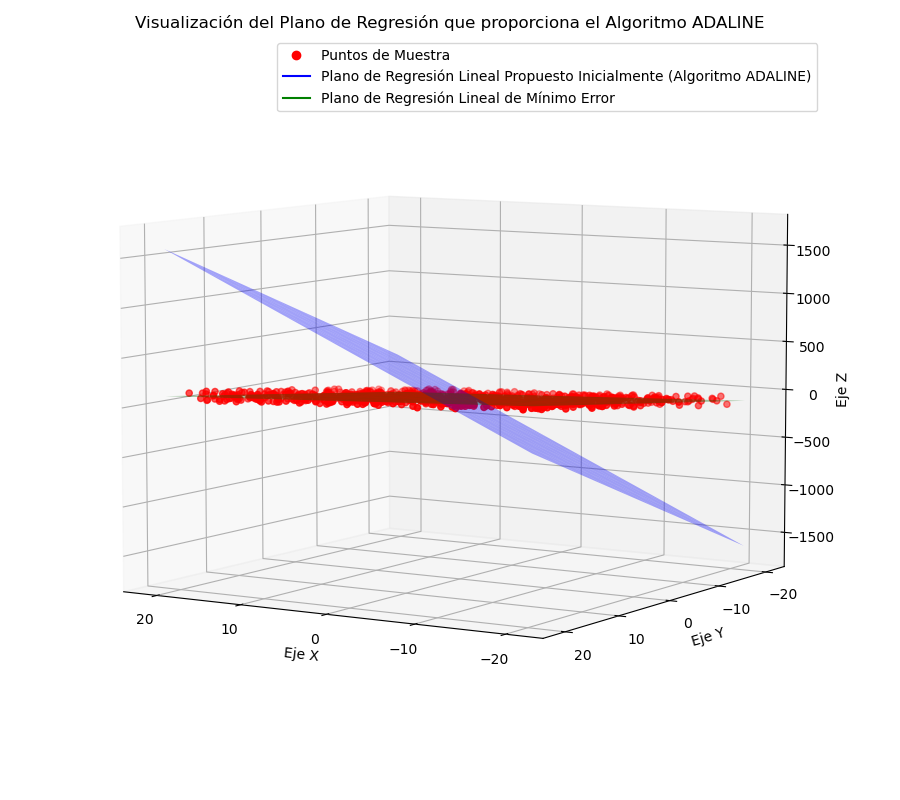

/tmp/ipykernel_16566/1877497478.py:46: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')


In [12]:
%matplotlib notebook

listaPuntosPorCoordenadasRespectivas = obtenerListasCoordenadasRespectivas(listaPuntosMuestra, numeroDimensiones)
valoresCoordenadasXPuntos = listaPuntosPorCoordenadasRespectivas[0]
valoresCoordenadasYPuntos = listaPuntosPorCoordenadasRespectivas[1]
valoresCoordenadasZPuntos = None
minimoEjeX = np.min(valoresCoordenadasXPuntos) - 1
maximoEjeX = np.max(valoresCoordenadasXPuntos) + 1
minimoEjeY = np.min(valoresCoordenadasYPuntos) - 1
maximoEjeY = np.max(valoresCoordenadasYPuntos) + 1
minimoEjeZ = None
maximoEjeZ = None

numeroMuestrasHiperplanoRegresion = 10
if numeroDimensiones == 2:
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    plt.figure(num = 1, figsize = (9, 8))
    plt.plot(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, 'ro', label = "Puntos de Muestra")
    plt.plot(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, 'b-', label = "Recta de Regresión Lineal Propuesto Inicialmente (Algoritmo ADALINE)")
    plt.plot(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, 'g-', label = "Recta de Regresión Lineal de Mínimo Error")
    plt.legend(loc = 'upper left')
    plt.xlabel("Eje X")
    plt.ylabel("Eje Y")
    plt.title("Visualización de la Recta de Regresión que proporciona el Algoritmo ADALINE")
    plt.grid(True)
    plt.show()
elif numeroDimensiones == 3:
    valoresCoordenadasZPuntos = listaPuntosPorCoordenadasRespectivas[2]
    minimoEjeZ = np.min(valoresCoordenadasZPuntos) - 1
    maximoEjeZ = np.max(valoresCoordenadasZPuntos) + 1
    
    listaValoresCoordenadaXHiperplanoBase = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoBase = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase = np.meshgrid(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase)
    listaValoresCoordenadaZHiperplanoBase = listaCoeficientesFuncionLinealBase[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoBase + listaCoeficientesFuncionLinealBase[numeroDimensiones - 1]
    listaValoresCoordenadaXHiperplanoMinimoError = np.linspace(minimoEjeX, maximoEjeX, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaYHiperplanoMinimoError = np.linspace(minimoEjeY, maximoEjeY, num = numeroMuestrasHiperplanoRegresion)
    listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError = np.meshgrid(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError)
    listaValoresCoordenadaZHiperplanoMinimoError = listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 3] * listaValoresCoordenadaXHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 2] * listaValoresCoordenadaYHiperplanoMinimoError + listaCoeficientesFuncionLinealMinimoError[numeroDimensiones - 1]
    
    currentFigure = plt.figure(num = 1, figsize = (9, 8))
    ax = currentFigure.gca(projection = '3d')
    ax.view_init(elev = 7, azim = 122) #Se ajusta la perspectiva manualmente de forma que se pueda visualizar los planos de separacion, los vectores de soporte y evidencia que separen los datos segun la clase a la que pertenecen (Si se cambia de plano para generar los puntos de muestra, se recomienda ajustar adecuadamente la perspectiva)
    ax.scatter(valoresCoordenadasXPuntos, valoresCoordenadasYPuntos, valoresCoordenadasZPuntos, c = 'r', marker = 'o')
    etiquetaLeyendaPuntos = mpl.lines.Line2D([0], [0], linestyle = "none", c = 'r', marker = 'o')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoBase, listaValoresCoordenadaYHiperplanoBase, listaValoresCoordenadaZHiperplanoBase, color = 'b', alpha = 0.35)
    etiquetaLeyendaPlano = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'b')
    ax.plot_surface(listaValoresCoordenadaXHiperplanoMinimoError, listaValoresCoordenadaYHiperplanoMinimoError, listaValoresCoordenadaZHiperplanoMinimoError, color = 'g', alpha = 0.35)
    etiquetaLeyendaPlanoMinimoError = mpl.lines.Line2D([0], [0], linestyle = "-", c = 'g')
    ax.set_xlabel("Eje X")
    ax.set_ylabel("Eje Y")
    ax.set_zlabel("Eje Z")
    ax.set_title("Visualización del Plano de Regresión que proporciona el Algoritmo ADALINE")
    ax.legend([etiquetaLeyendaPuntos, etiquetaLeyendaPlano, etiquetaLeyendaPlanoMinimoError], ["Puntos de Muestra", "Plano de Regresión Lineal Propuesto Inicialmente (Algoritmo ADALINE)", "Plano de Regresión Lineal de Mínimo Error"], numpoints = 1)
    plt.tight_layout()
    plt.show()

No hay archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


/tmp/ipykernel_16566/1364775899.py:31: RuntimeWarning: invalid value encountered in sqrt
  listaCoeficientesCorrelacion = [np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))]


<IPython.core.display.Javascript object>


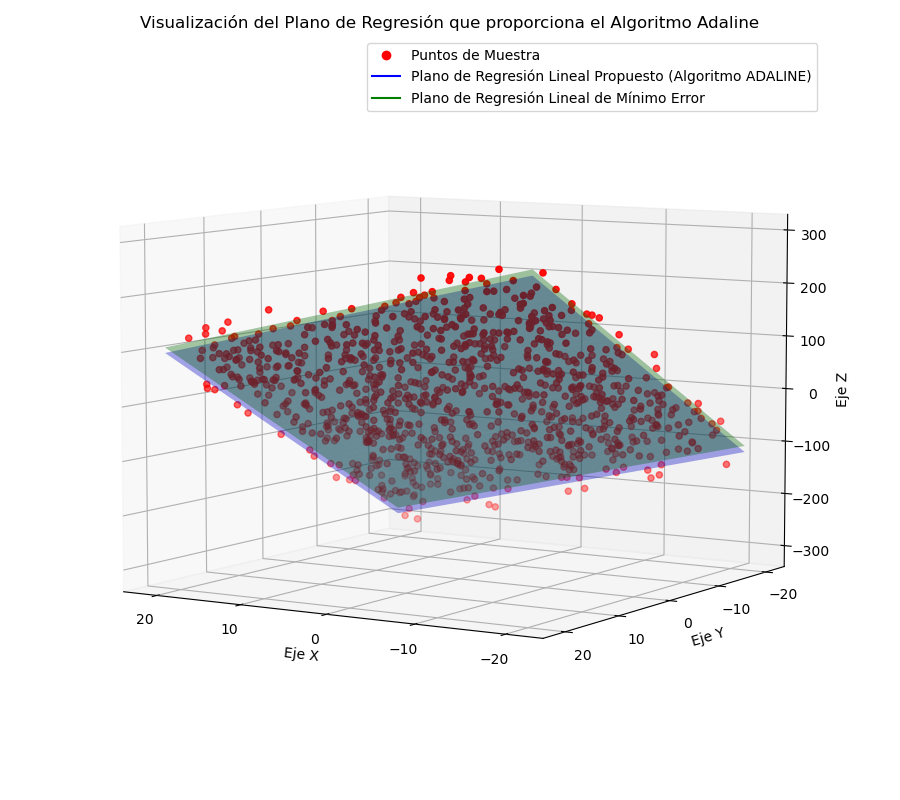

/tmp/ipykernel_16566/1364775899.py:104: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = currentFigure.gca(projection = '3d')
/tmp/ipykernel_16566/1364775899.py:112: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_16566/1364775899.py:112: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValoresSalidaModelo))
/tmp/ipykernel_16566/1364775899.py:112: RuntimeWarning: invalid value encountered in sqrt
  coeficienteCorrelacion = np.sqrt(r2_score(listaValoresSalida, listaValore

In [13]:
errorCuadraticoMedioPermitido = minimoErrorCuadraticoMedio + 2.0

listaCoeficientesFuncionLinealRegresion, listaCoeficientesCorrelacion, listaErroresCuadraticosMedios, listaErroresTipicosTotales, listaErroresTipicosMedios, numeroPasos = algoritmoADALINE(listaCoeficientesFuncionLinealBase, listaCoeficientesFuncionLinealMinimoError, listaPuntosMuestra, listaAbscisasPuntosMuestra, np.array(listaValoresSalidaY.tolist()), errorCuadraticoMedioPermitido, tasaAprendizaje, numeroDimensiones)

In [14]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución (Hasta esta parte): {} minuto(s) y {} segundo(s)".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución (Hasta esta parte): 1 minuto(s) y 16 segundo(s)


In [15]:
animationFilename = ""
if (numeroDimensiones == 2 or numeroDimensiones == 3) and numeroPasos > 0:
    animationFilename = createAnimationFromImageFilesAtSomeDirectory(searchFolderPath, imageFileExtensionsList, nombreArchivoAnimacion, animationFileExtension, framesPorSegundoAnimacion)
    mensajeConfirmacion = deleteFilesOfSomeExtensionAtSomeDirectory(searchFolderPath, imageFileExtensionsList)
    print(printColouredText(mensajeConfirmacion, colorTextoRojo))

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (794, 790) to (800, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Se ha(n) ajustado 616 imágen(es) a un tamaño común que es de 794x790 como máximo de ancho por máximo de alto


[swscaler @ 0x6000780] Warning: data is not aligned! This can lead to a speed loss


Se ha creado el archivo ./Figuras/Animación del ADALINE.mp4
Hay 616 archivos con extensión ['.jpg'] para eliminar, en la carpeta ./Figuras/


In [16]:
Video(animationFilename, width = 850)

In [17]:
listaCoeficientesHiperplanoRegresion = []
for indice in range(numeroDimensiones):
    if indice == numeroDimensiones - 1:
        listaCoeficientesHiperplanoRegresion.append(1.0)
    listaCoeficientesHiperplanoRegresion.append(-listaCoeficientesFuncionLinealRegresion[indice])
textoEcuacionHiperplanoRegresion = crearTextoEcuacionHiperplano(listaCoeficientesHiperplanoRegresion)
if numeroDimensiones == 2:
    print("El modelo de regresión (recta que da el algoritmo ADALINE) está dada por la ecuación:")
elif numeroDimensiones == 3:
    print("El modelo de regresión (plano que da el algoritmo ADALINE) está dado por la ecuación:")
elif numeroDimensiones >= 4:
    print("El modelo de regresión (hiperplano que da el algoritmo ADALINE) está dado por la ecuación:")
display(Math(textoEcuacionHiperplanoRegresion))

textoFuncionLinealRegresion = crearTextoFuncionLineal(listaCoeficientesFuncionLinealRegresion)
if numeroDimensiones == 2:
    print("Como función, el modelo de regresión aproximado (recta que da el algoritmo ADALINE), es:")
elif numeroDimensiones == 3:
    print("Como función, el modelo de regresión aproximado (plano que da el algoritmo ADALINE), es:")
elif numeroDimensiones >= 4:
    print("Como función, el modelo de regresión aproximado (hiperplano que da el algoritmo ADALINE), es:")

display(Math(textoFuncionLinealRegresion))

El modelo de regresión (plano que da el algoritmo ADALINE) está dado por la ecuación:


<IPython.core.display.Math object>

Como función, el modelo de regresión aproximado (plano que da el algoritmo ADALINE), es:


<IPython.core.display.Math object>

In [18]:
if numeroDimensiones == 2:
    print("Al ejecutar el algoritmo ADALINE, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar una recta de regresión que estime los puntos de muestra")
elif numeroDimensiones == 3:
    print("Al ejecutar el algoritmo ADALINE, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un plano de regresión que estime los puntos de muestra")
elif numeroDimensiones >= 4:
    print("Al ejecutar el algoritmo ADALINE, se requirió de", printColouredText(str(numeroPasos) + " paso(s)", colorTextoVerde), "para encontrar un hiperplano de regresión que estime los puntos de muestra")

Al ejecutar el algoritmo ADALINE, se requirió de 616 paso(s) para encontrar un plano de regresión que estime los puntos de muestra


<IPython.core.display.Javascript object>


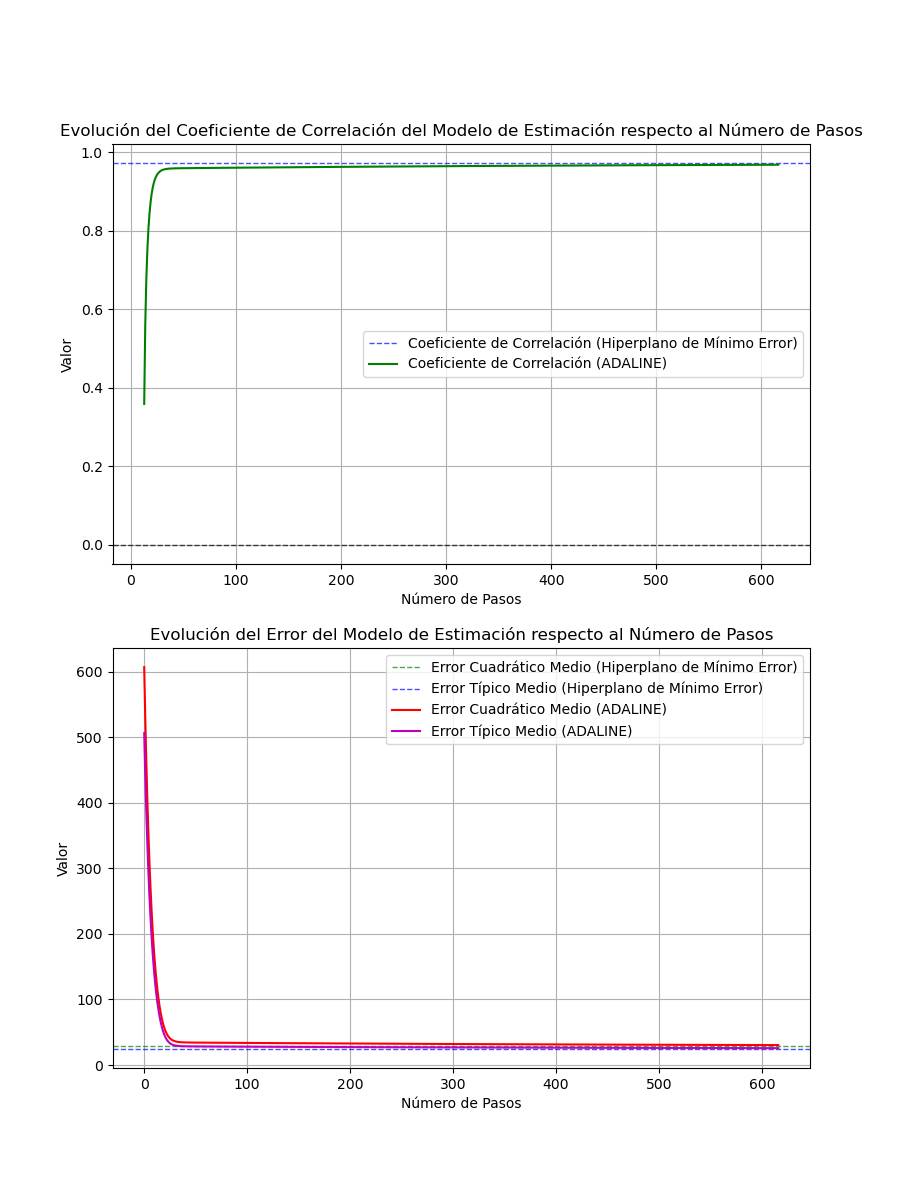

In [19]:
if numeroPasos > 0:
    plt.figure(num = 3, figsize = (9, 12))
    plt.subplot(211)
    plt.axhline(y = coeficienteCorrelacionModeloMinimoError, color = 'b', linestyle = '--', label = 'Coeficiente de Correlación (Hiperplano de Mínimo Error)', linewidth = 1, alpha = 0.7)
    plt.axhline(y = 0.0, color = 'k', linestyle = '--', linewidth = 1, alpha = 0.7)
    plt.plot(listaCoeficientesCorrelacion, color = 'g', linestyle = '-', label = 'Coeficiente de Correlación (ADALINE)', linewidth = 1.5)
    plt.title('Evolución del Coeficiente de Correlación del Modelo de Estimación respecto al Número de Pasos')
    plt.xlabel('Número de Pasos')
    plt.ylabel('Valor')
    plt.legend(labelcolor = 'k', loc = 'center right')
    plt.grid(True)
    plt.subplot(212)
    plt.axhline(y = minimoErrorCuadraticoMedio, color = 'g', linestyle = '--', label = 'Error Cuadrático Medio (Hiperplano de Mínimo Error)', linewidth = 1, alpha = 0.7)
    plt.axhline(y = minimoErrorTipicoMedio, color = 'b', linestyle = '--', label = 'Error Típico Medio (Hiperplano de Mínimo Error)', linewidth = 1, alpha = 0.7)
    plt.plot(listaErroresCuadraticosMedios, color = 'r', linestyle = '-', label = 'Error Cuadrático Medio (ADALINE)', linewidth = 1.5)
    plt.plot(listaErroresTipicosMedios, color = 'm', linestyle = '-', label = 'Error Típico Medio (ADALINE)', linewidth = 1.5)
    plt.title('Evolución del Error del Modelo de Estimación respecto al Número de Pasos')
    plt.xlabel('Número de Pasos')
    plt.ylabel('Valor')
    plt.legend(labelcolor = 'k', loc = 'upper right')
    plt.grid(True)
    plt.show()

In [20]:
endInstantTime = time.time()
fullRunningTime = endInstantTime - startInstantTime
runningTimeInMinutes = int(fullRunningTime / 60)
runningTimeInSeconds = int(fullRunningTime % 60)
print("Tiempo de Ejecución: {} minuto(s) y {} segundo(s)".format(runningTimeInMinutes, runningTimeInSeconds))

Tiempo de Ejecución: 1 minuto(s) y 23 segundo(s)
